In [1]:
import yfinance as yf
import numpy as np

df  = yf.download("AAPL", start='2000-01-01', end='2023-01-09')

df.reset_index(drop=True, inplace=True)

df.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
0,0.936384,1.004464,0.907924,0.999442,0.851942,535796800
1,0.966518,0.987723,0.903460,0.915179,0.780115,512377600
2,0.926339,0.987165,0.919643,0.928571,0.791531,778321600
3,0.947545,0.955357,0.848214,0.848214,0.723033,767972800
4,0.861607,0.901786,0.852679,0.888393,0.757282,460734400


In [2]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [3]:
df = df.astype('float64')

In [4]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
X = df.drop(columns=['Adj Close'])
y = df['Adj Close']

<Figure size 1600x800 with 0 Axes>

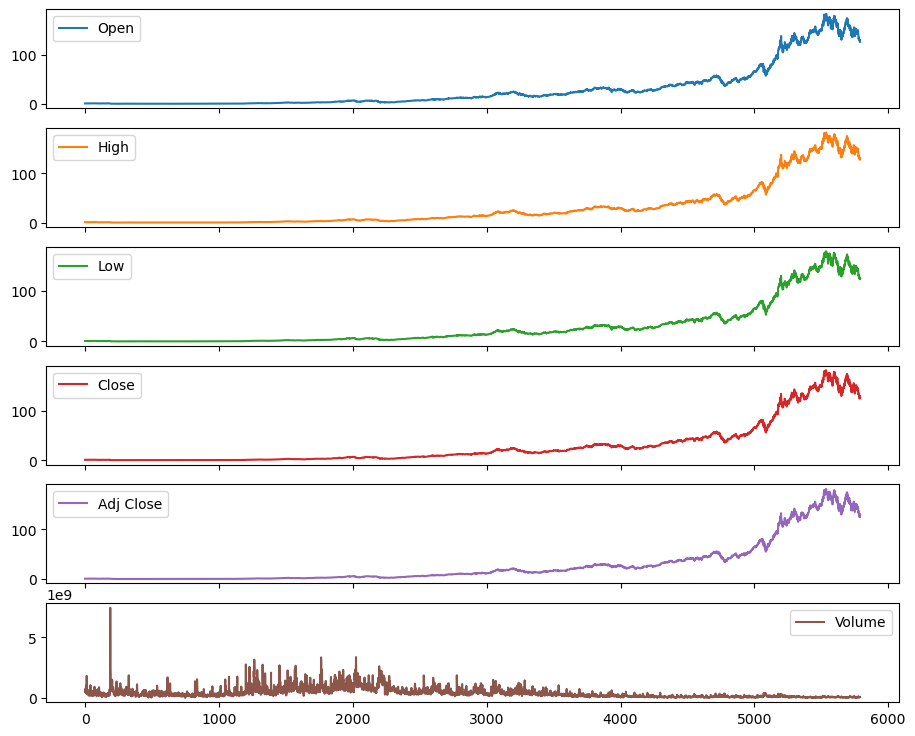

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8)) # resizing the plot
axes = df.plot(figsize=(11, 9), subplots = True)
plt.show();

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

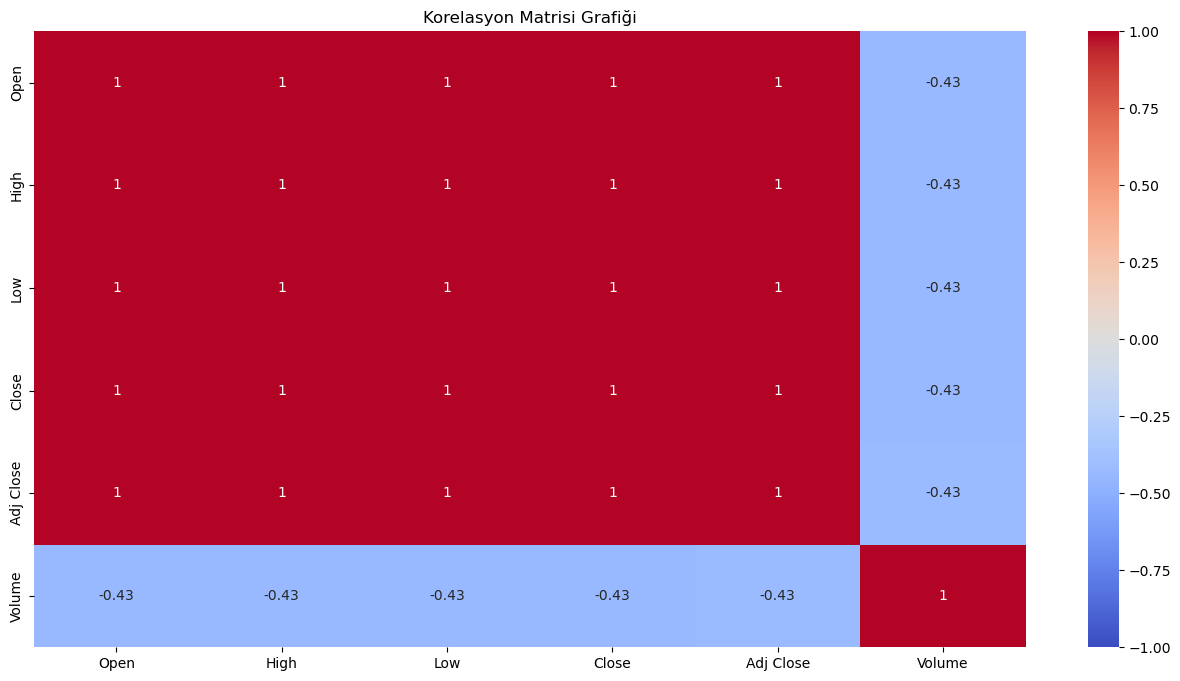

In [9]:
corr = df.corr()
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 8))
 
sns.heatmap(ax = ax, \
            data = corr, \
            annot = True, \
            cmap = "coolwarm", \
            vmin = -1, vmax= 1, center = 0)
 
ax.set_title("Korelasyon Matrisi Grafiği")
 
plt.show()

In [10]:
X_train.shape[1]

5

In [11]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
# Building the Input Layer
input_layer = Input(shape =(X_train.shape[1], ))
  
# Building the Encoder network
encoded = Dense(4, activation ='tanh')(input_layer)
encoded = Dense(3, activation ='tanh')(encoded)
encoded = Dense(2, activation ='relu')(encoded)
  


# Building the Decoder network
decoded = Dense(2, activation ='tanh',name='bottleneck_layer')(encoded)

decoded = Dense(3, activation ='tanh')(decoded)
decoded = Dense(4, activation ='tanh')(decoded)
  
# Building the Output Layer
output_layer = Dense(X_train.shape[1], activation ='relu')(decoded)


# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adadelta", loss ="mse")


  
# Training the Auto-encoder network
autoencoder.fit(X_train, X_train,
                batch_size = 16, epochs = 50, 
                shuffle = True, validation_data=(X_test, X_test))



Epoch 1/50
290/290 [==============================] - 1s 2ms/step - loss: 0.0648 - val_loss: 0.0646
Epoch 2/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0643
Epoch 3/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0641
Epoch 4/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0639
Epoch 5/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0636
Epoch 6/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0634
Epoch 7/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0631
Epoch 8/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0629
Epoch 9/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0626
Epoch 10/50
290/290 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0624

In [12]:
bottleneck_output = autoencoder.get_layer('bottleneck_layer').output

model_bottleneck = Model(inputs = autoencoder.input, outputs = bottleneck_output)

In [13]:
X_train = model_bottleneck.predict(X_train)

145/145 [==============================] - 0s 699us/step


In [14]:
X_train.shape[1]

2

In [15]:
X_test = model_bottleneck.predict(X_test)

37/37 [==============================] - 0s 656us/step


In [16]:
X_test.shape[1]

2

In [17]:
from sklearn.svm import SVR
clf = SVR(kernel='rbf')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [18]:
y_pred =pd.DataFrame(y_pred).set_index(y_test.index)

In [19]:
y_test = y_test.sort_index()

In [20]:
y_pred = y_pred.sort_index()

In [21]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

27.386362062050583

In [22]:
len(y_test)

1159

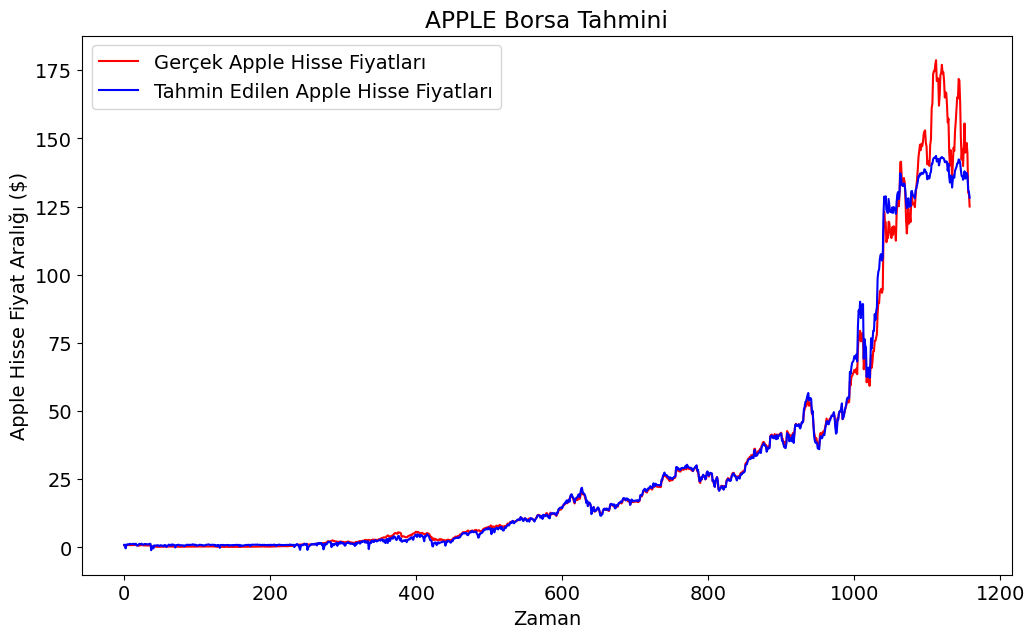

In [23]:
import matplotlib.pyplot as plt

predicted_stock_price = y_pred
actual_stock_price = y_test

plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

plt.plot(np.arange(1159),actual_stock_price, color="red", label="Gerçek Apple Hisse Fiyatları")
plt.plot(np.arange(1159),predicted_stock_price, color="blue", label="Tahmin Edilen Apple Hisse Fiyatları")
plt.title("APPLE Borsa Tahmini")
plt.xlabel("Zaman")
plt.ylabel("Apple Hisse Fiyat Aralığı ($)")
plt.legend();